In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
import os

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("huthayfahodeb/captcha-dataset")

print("Path to dataset files:", path)

100%|██████████| 142M/142M [00:08<00:00, 17.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2


In [59]:
os.listdir(path)

['validation-images', 'captcha_data.csv', 'train-images', 'test-images']

In [60]:
train_images = os.path.join(path,'train-images','train-images')
test_images = os.path.join(path,'test-images','test-images')
val_images = os.path.join(path,'validation-images','validation-images')

In [61]:
df = pd.read_table(os.path.join(path,'captcha_data.csv'), sep=',', dtype={'solution': str})

In [62]:
df.head()

,image_path,solution
0,train-images/image_train_1.png,000073
1,train-images/image_train_2.png,000372
2,train-images/image_train_3.png,000454
3,train-images/image_train_4.png,000634
4,train-images/image_train_5.png,000716


In [63]:
def preprocess_solution(solution):
    return np.array([int(char) for char in solution], dtype=np.float32)

In [64]:
train_df = df[df['image_path'].str.startswith('train-images/')]
test_df = df[df['image_path'].str.startswith('test-images/')]
val_df = df[df['image_path'].str.startswith('validation-images/')]

In [65]:
train_image_paths = train_df['image_path'].values
train_solutions = train_df['solution'].apply(preprocess_solution).values

test_image_paths = test_df['image_path'].values
test_solutions = test_df['solution'].apply(preprocess_solution).values

val_image_paths = val_df['image_path'].values
val_solutions = val_df['solution'].apply(preprocess_solution).values

In [66]:
train_image_paths[:5]

array(['train-images/image_train_1.png', 'train-images/image_train_2.png',
       'train-images/image_train_3.png', 'train-images/image_train_4.png',
       'train-images/image_train_5.png'], dtype=object)

In [67]:
train_solutions[:5]

array([array([0., 0., 0., 0., 7., 3.], dtype=float32),
       array([0., 0., 0., 3., 7., 2.], dtype=float32),
       array([0., 0., 0., 4., 5., 4.], dtype=float32),
       array([0., 0., 0., 6., 3., 4.], dtype=float32),
       array([0., 0., 0., 7., 1., 6.], dtype=float32)], dtype=object)

In [77]:
def read_images(image_paths, subset_path=''):

    images = [np.array(Image.open(f"{subset_path}{path}").convert('RGB')) for path in image_paths]
    return  np.array(images)

In [87]:
train_images = read_images(train_image_paths, subset_path='/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/train-images/')
test_images = read_images(test_image_paths, subset_path='/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/test-images/')
val_images = read_images(val_image_paths, subset_path='/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/validation-images/')

In [88]:
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Validation images shape: {val_images.shape}")

Train images shape: (6000, 50, 200, 3)
Test images shape: (2000, 50, 200, 3)
Validation images shape: (2000, 50, 200, 3)


In [89]:
train_solutions = np.vstack(train_solutions)
test_solutions = np.vstack(test_solutions)
val_solutions = np.vstack(val_solutions)

In [90]:
print(f"Train solutions shape: {train_solutions.shape}")
print(f"Test solutions shape: {test_solutions.shape}")
print(f"Validation solutions shape: {val_solutions.shape}")

Train solutions shape: (6000, 6)
Test solutions shape: (2000, 6)
Validation solutions shape: (2000, 6)


In [142]:
def build_model(input=(50, 200, 3), num_classes=6):
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 200, 3))

  base_model.trainable = True

  inputs = Input(shape=(50, 200, 3))

  x = base_model(inputs)

  x = layers.GlobalAveragePooling2D()(x)

  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(6)(x)

  model = Model(inputs, outputs)

  model.compile(optimizer='adam', loss='mse',metrics=["acc"])

  model.summary()

  return model

In [143]:
model = build_model()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 50, 200, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,769,670 (94.49 MB)

 Trainable params: 24,716,550 (94.29 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [144]:
history = model.fit(train_images, train_solutions, epochs=20, validation_data=(val_images, val_solutions),callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 248ms/step - acc: 0.4794 - loss: 6.0115 - val_acc: 0.1630 - val_loss: 52.2653
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - acc: 0.6415 - loss: 2.2793 - val_acc: 0.6290 - val_loss: 4.2456
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - acc: 0.6714 - loss: 1.7861 - val_acc: 0.7325 - val_loss: 1.9054
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - acc: 0.6809 - loss: 1.7304 - val_acc: 0.7570 - val_loss: 0.9634
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - acc: 0.7002 - loss: 1.4568 - val_acc: 0.7705 - val_loss: 1.1904
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - acc: 0.7051 - loss: 1.3918 - val_acc: 0.7445 - val_loss: 0.6779
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - acc: 0.7259 - loss: 1.2636 - val_acc: 0.7940 - val_loss: 0.5402
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - acc: 0.7171 - loss: 1.2128 - val_acc: 0.8165 - val_loss: 0.5691
Epoch 9/20
188/188 ━━━━━━━━━━━

In [145]:
loss,acc = model.evaluate(test_images,test_solutions)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.7770 - loss: 0.4616


In [146]:
def output_to_solution(prediction):
    prediction = np.round(prediction).astype(int)

    solution = ''.join(map(str, prediction[0])).lstrip('0')

    return solution

def predict_and_plot(image_path, model):
    img = Image.open(image_path)

    img_array = np.array(img)

    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    prediction = output_to_solution(prediction)

    plt.imshow(img)
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.show()

    return prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


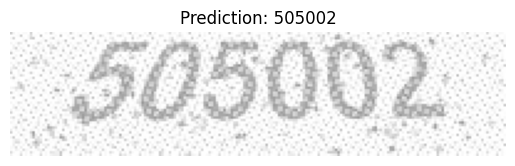

Predicted output: 505002


In [151]:
image_path = '/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/test-images/test-images/image_test_1009.png'
prediction = predict_and_plot(image_path, model)
print("Predicted output:", prediction)